In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Simply about Word2Vec (Quora dataset)



## Table of contents
1. [Introduction](#introduction)
2. [What is Word2Vec?](#word2vec)
3. [Training of Word2Vec](#training)
4. [Exploring the trained Word2Vec model](#exploring)
5. [Playing with the trained Word2Vec model ](#playing)
6. [When can we use Word2Vec?](#usage)



## Introduction <a name="introduction"></a>

If you have never used Word2Vec, then this notebook is for you! Here I will apply Word2Vec to the questions asked in Quora. The goal of the notebook is to better understand how Word2Vec works. Basically I wanted to resolve my personal doubts regarding Word2Vec. I will be very glad if my small analysis would be useful for someone else.

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [18]:
df[df["is_duplicate"] ==1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...,...
404280,404280,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
404281,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404282,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1
404284,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


In [3]:
df.shape

(404290, 6)

The Quora dataset consists of 404.290 rows and 6 columns. To reach the goal of this notebook, I am only interested in columns that contain questions. These columns are "question1" and "question2". To reduce training time, I will only use the column "question1".

## What is Word2Vec? <a name="word2vec"></a>

Word2Vec is one of many different word embedding techniques. In turn, word embedding is one of the most popular representation of document vocabulary. Thus, we get the following hierarchy:

* Document vocabulary representation -> Word embedding -> Word2Vec

So, what is word embedding? **Word embedding** is a vector representation of a word. For example, let's consider the folling three phases: 
* Agama is a reptile.
* Snake is a reptile.
* Reptile is a cold-blooded animal.

The **dictionary** of this corpus of text (three phrases) consists of all unique words:
> ["agama", "reptile", "snake", "a", "is", "cold-blooded", "animal"]

A simple vector representation of the word "agama" would be:
> [1, 0, 0, 0, 0, 0, 0]

where 1 stands for the word "agama" in our dictionary. This word embedding is called one-hot encoding. For any word, the length of a vector is always 7 in our example, because the dictionary consists of 7 unique words. This word embedding technique is very simple, but has a tremendous disadvantage. Let's take vector representations of two words: 
> "agama" and "reptile" -> [1, 0, 0, 0, 0, 0, 0] and [0, 1, 0, 0, 0, 0, 0]

These two vectors provide no useful information regarding the relationships that may exist between the "agama" and "reptile". In other words, the similarity between words is not captured by the one-hot encoding. Loosely speaking, one-hot encoding does not enable the system making conclusions about the word "agama" given the word "reptile" (for example, such that agama is a cold-blooded animal).

**Word2Vec is a more sophisticated word embedding technique**. This technique is based on the idea that words that occur in the same **contexts** tend to have similar meanings. I like this definition from Wikipedia 

> Word2Vec is a **two-layer neural network** that takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space (Wikipedia).

Below I provide one of the best graphic representations of Word2Vec's word embedding that I found on Internet. This picture gives an intuition about how word embedding looks like in Word2Vec.

![](http://adriancolyer.files.wordpress.com/2016/04/word2vec-distributed-representation.png?w=566&zoom=2)

Ref: [The amazing power of word vectors](http://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/)

**Word2Vec itself is not a deep neural network**, but it turns input text into a numerical form that deep neural networks can process as inputs.

## Training of Word2Vec <a name="training"></a>

To train the Word2Vec two-layer neural network, the only thing that we need to do is to change the format of Quora dataset. In particular, I will transform the column "question1" into a list of lists. I will use the function "simple_preprocess" of GenSim package in order to transform each question (row) into a set of tokens, for example: "what is your name" -> "what", "is", "your", "name". 

In [4]:
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))
    
documents = []
for index, row in df.iterrows():
    documents.append(read_questions(row,"question1"))
    if row["is_duplicate"] == 0:
        documents.append(read_questions(row,"question2"))

In [5]:
print("List of lists. Let's confirm: ", type(documents), " of ", type(documents[0]))

List of lists. Let's confirm:  <class 'list'>  of  <class 'list'>


Now Word2Vec will retrieve all unique words from all sub-lists of "documents", thereby constructing the vocabulary (unique words). 

In [6]:
model = gensim.models.Word2Vec(size=150, window=10, min_count=2, sg=1, workers=10)
model.build_vocab(documents)  # prepare the model vocabulary

Below I provide the definition of four parameters that we used to define a Word2Vec model:

* **size:** The size means the dimensionality of word vectors. It defines the number of tokens used to represent each word. For example, rake a look at the picture above. The size would be equal to 4 in this example. Each input word would be represented by 4 tokens: King, Queen, Women, Princess.  Rule-of-thumb: If a dataset is small, then size should be small too. If a dataset is large, then size should be greater too. It's the question of tuning.

* **window:** The maximum distance between the target word and its neighboring word. For example, let's take the phrase "agama is a reptile " with 4 words (suppose that we do not exclude the stop words). If window size is 2, then the vector of word "agama" is directly affected by the word "is" and "a". Rule-of-thumb: a smaller window should provide terms that are more related (of course, the exclusion of stop words should be considered).

* **min_count:** Ignores all words with total frequency lower than this. For example, if the word frequency is extremally low, then this word might be considered as unimportant.

* **sg:** Selects training algorithm: 1 for Skip-Gram; 0 for CBOW (Continuous Bag of Words).

* **workers:** The number of worker threads used to train the model.

More details about input parameters can be found [here](http://radimrehurek.com/gensim/models/word2vec.html).

Once the vocabulary is created and the Word2Vec model is specified, I will train this model by calling "train" function.

In [7]:
model.train(sentences=documents, total_examples=len(documents), epochs=model.iter)

C:\Users\mahendra.chouhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(25465749, 35144510)

Let's see what happens when the function "train" is executed. I found a diagram (see below) that shows a Skip-Gram model architecture to produce a distributed representation of words. To understand this diagram, we should consider the size of vocablurary and the dimensionality of the word vectors (the parameter "size"). In our example, these are equal to 47.366 words and 150 tokens, respectively. If we take the word “immigration”, it will be one of the words in the 47.366 word vocabulary.  Therefore we can initially represent the word "immigration" as a 47.366 length one-hot vector.  We then link this input vector to a 150 node hidden layer.  There are totally 150 weights connecting the input layer and the hidden layer.  The activations of the nodes in this hidden layer are simply linear summations of the weighted inputs, e.g. `ohe*w1+ohe*w2+...+ohe*w150`.  These nodes are then fed into a softmax output layer.  During training, we want to change the weights of this neural network so that words surrounding “immigration” have a higher probability in the softmax output layer.  So, for instance, if our text data set has a lot of questions related to the immigration in Canada, we would want our network to assign large probabilities to words like “Canada”, "Australia"  (given lots of sentences containing “the immigration to Canada or Australia”).

![](https://preview.ibb.co/iuzji0/Word2-Vec-skip-gram.jpg)

We finished training our Word2Vec model. What's next? The funny thing is that next we abandon the softmax layer and just use the 47.366 x 150 weight matrix as our word embedding lookup table. Sounds weird, isn't it? The only goal was to get the weights of the hidden layer. These weights are essentially the word embeddings that we had to learn. Once we know these word embeddings, we do not need the whole Word2Vec network anymore.

## Exploring the trained Word2Vec model <a name="exploring"></a>

The learned vocabulary of tokens (words) is stored in "model.wv.vocab". In our case, the vocabulary includes 47.366 unique words. 

In [8]:
word_vectors = model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

what
is
the
step
by
guide
to
invest
in
share


In [9]:
len(word_vectors.vocab)

47336

The embedded vectors for a specific token are stored in a KeyedVectors instance in "model.wv". We can see that the length of a word vector is equal to 150 as we defined by the parameter "size":

In [29]:
vector = model.wv["find"]  # numpy vector of a word
len(vector)

150

In [30]:
vector

array([ 4.04283285e-01, -2.67674565e-01,  2.04147279e-01, -3.42464328e-01,
        1.16926715e-01,  4.29689378e-01, -3.06203306e-01,  2.24766627e-01,
        1.74896434e-01,  3.19926709e-01,  9.50790346e-02,  1.71366736e-01,
       -1.06310479e-01,  1.57839898e-02, -1.90843865e-01,  9.05614987e-04,
        4.65423822e-01, -2.48587176e-01,  2.33261272e-01, -2.66973495e-01,
       -2.61952337e-02, -5.93901873e-02,  7.94887900e-01,  2.07121983e-01,
       -1.31581221e-02,  1.67818472e-01,  4.67964381e-01,  3.34748566e-01,
        6.32300913e-01, -3.01560700e-01, -3.33615780e-01,  5.31056046e-01,
       -5.00213727e-03, -2.29121536e-01,  3.00828308e-01, -4.13524777e-01,
       -3.58969390e-01, -6.77763999e-01, -3.86540502e-01,  9.88670290e-02,
        4.56103295e-01,  1.95078403e-01,  6.48480654e-01, -1.58554167e-01,
        6.28769219e-01, -9.36108604e-02, -9.25535023e-01,  4.23422962e-01,
        1.70862272e-01,  1.22705519e-01,  1.14552930e-01,  2.37999648e-01,
       -1.84992909e-01, -

We can now create a two-dimensional semantic representation of word embeddings using t-SNE.

In [12]:
wanted_words = []
count = 0
for word in word_vectors.vocab:
    if count<150:
        wanted_words.append(word)
        count += 1
    else:
        break
wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)
wanted_vocab

{'what': <gensim.models.keyedvectors.Vocab at 0x224861cee08>,
 'is': <gensim.models.keyedvectors.Vocab at 0x224861ce1c8>,
 'the': <gensim.models.keyedvectors.Vocab at 0x224861cefc8>,
 'step': <gensim.models.keyedvectors.Vocab at 0x224861ceec8>,
 'by': <gensim.models.keyedvectors.Vocab at 0x224861d10c8>,
 'guide': <gensim.models.keyedvectors.Vocab at 0x224861d1148>,
 'to': <gensim.models.keyedvectors.Vocab at 0x224861d1188>,
 'invest': <gensim.models.keyedvectors.Vocab at 0x224861d11c8>,
 'in': <gensim.models.keyedvectors.Vocab at 0x224861d1088>,
 'share': <gensim.models.keyedvectors.Vocab at 0x224861d1108>,
 'market': <gensim.models.keyedvectors.Vocab at 0x224861d1208>,
 'india': <gensim.models.keyedvectors.Vocab at 0x224861d1248>,
 'story': <gensim.models.keyedvectors.Vocab at 0x224861d1288>,
 'of': <gensim.models.keyedvectors.Vocab at 0x224861d12c8>,
 'kohinoor': <gensim.models.keyedvectors.Vocab at 0x224861d1308>,
 'koh': <gensim.models.keyedvectors.Vocab at 0x224861d1348>,
 'noor':

In [13]:
X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)

C:\Users\mahendra.chouhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
C:\Users\mahendra.chouhan\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\mahendra.chouhan\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


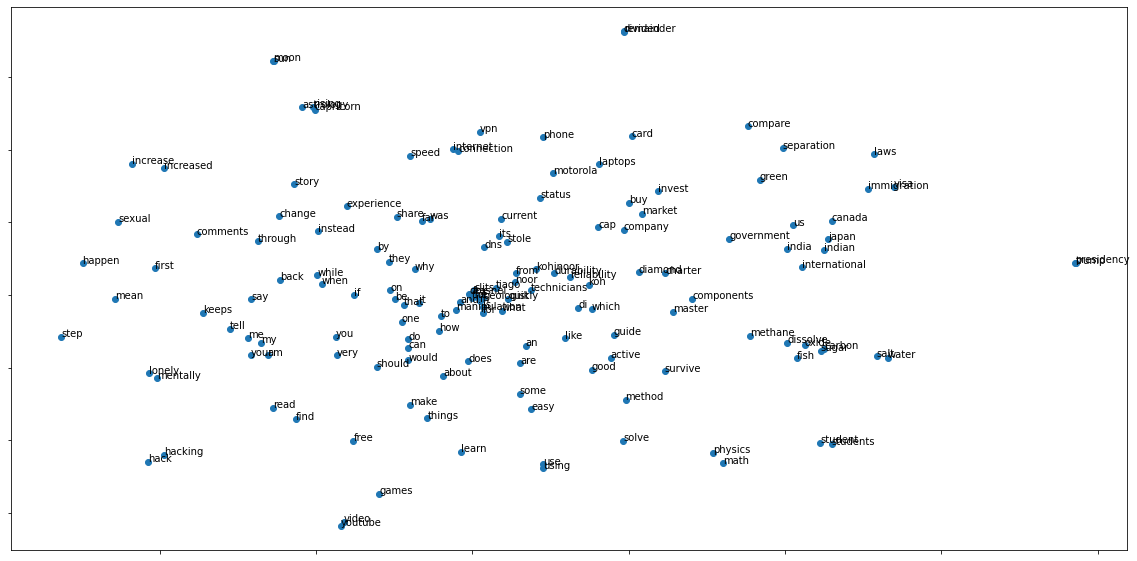

In [14]:
#Plot the t-SNE output
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
_ = plt.show()

Not that bad. It's interesting to see that, for example, the word pairs "motorola" and "phone" or "youtube" and "video" are located quite close to each other. It means that these words appeared in the same context in the corpus of text.

## Playing with the trained Word2Vec model <a name="playing"></a>

Now we will see what we can actually do with our trained Word2Vec model. This overview does not pretend to be exhaustive. I will only check the most popular functionalities:
* Given a word, find most similar words
* Given words A and B, find other words that are similar to A and opposite to B
* Given a sequence of words, find an odd word

This first example shows a simple case of looking up top 5 words similar to the word "phone". To do this, I will call the "most_similar" function and provide the word "phone" as the positive example. This returns the top 5 similar words: "mobile", "phones", "smartphone", "iphone" and "device". 

You may notice that there is no word "motorola" in the list of top 5 similar words, while the word "motorola" appears in t-SNE graphic. Please remember that t-SNE was applied on a small subset of vocabulary (150 words). Therefore, the words "mobile", "phones", "smartphone", etc. were simply not included in these 150 words and therefore they have not appeared on the t-SNE graphic.

In [26]:
w1 = "be"
model.wv.most_similar(positive=w1, topn=10)

[('disastrous', 0.5656231641769409),
 ('valparai', 0.5448888540267944),
 ('mirik', 0.5446635484695435),
 ('tamiya', 0.5435508489608765),
 ('topslip', 0.541578471660614),
 ('horsley', 0.5403908491134644),
 ('bulandshahr', 0.5376573204994202),
 ('saharanpur', 0.535821259021759),
 ('biharinath', 0.5344330668449402),
 ('khandala', 0.5343244671821594)]

Next, given positive and negative words, we will find top 2 words that are similar to positivie words and opposite to negative words.

In [31]:
w1 = ["be","can"]
w2 = ["find"]
model.wv.most_similar (positive=w1,negative=w2,topn=2)

[('could', 0.5566522479057312), ('able', 0.5018189549446106)]

Finally, I will use Word2Vec to find odd items given a list of items "government","corruption" and "peace". For most of people this is a rhetorical question.

In [36]:
model.wv.doesnt_match(["be", "can", "find"])

'be'

Do you agree with the opinion of Word2Vec?:)


## When can we use Word2Vec? <a name="usage"></a>

There are many application scenarios for Word2Vec: sentiment analysis, recommender systems, etc. For example, imagine that you have tags for a large amount of questions in Quora. Given a tag, you want to find similar tags in order to recommend them to a user for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. 